<a href="https://colab.research.google.com/github/samalpartha/Alzeimers/blob/main/NeuroLens_Explainable_MRI_AI_for_Alzheimer's_Staging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NeuroLens: Explainable MRI AI for Alzheimer's Staging

## Project Overview
Deep learning system that classifies Alzheimer's stages from brain MRI scans using the Hack4Health dataset. This project fine-tunes a 2D/3D CNN with substantial data augmentation and applies Grad-CAM for explainability and comprehensive error analysis.

## Key Features
- Multi-stage Alzheimer's classification from MRI scans
- Advanced data augmentation pipeline
- 2D/3D CNN architecture
- Grad-CAM visualization for model interpretability
- Comprehensive error analysis and performance metrics

## Dataset
**Alzheimer MRI Disease Classification Dataset**
- Path: `/kaggle/input/alzheimer-mri-disease-classification-dataset`
- File: `train-00000-of-00001-c08a401c53fe5312.parquet`

## 1. Environment Setup & Dependencies

In [7]:
# Install required packages
!pip install -q pandas pillow kagglehub ipywidgets numpy matplotlib pyarrow tensorflow scikit-learn seaborn opencv-python

# Set random seeds for reproducibility
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Environment setup complete!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

Environment setup complete!
TensorFlow version: 2.19.0
GPU Available: []


In [8]:
# Import all necessary libraries
import pandas as pd
from PIL import Image
import io
import numpy as np
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import cv2

# TensorFlow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.optimizers import Adam

print("All imports successful!")

All imports successful!


## 2. Data Loading & Preprocessing

In [9]:
# Kaggle API Authentication - Direct Setup
import os
import json

# Your Kaggle credentials
kaggle_username = "parthasamal"
kaggle_key = "KGAT_fde7ef08afce4428cb35c261b9c6f2e1"

# Create .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Create kaggle.json with credentials
kaggle_config = {
    "username": kaggle_username,
    "key": kaggle_key
}

# Write kaggle.json file
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_config, f)

# Set proper permissions
os.chmod('/root/.kaggle/kaggle.json', 0o600)

print("✅ Kaggle authentication configured successfully!")
print(f"Username: {kaggle_username}")
print("You can now download datasets from Kaggle.")

✅ Kaggle authentication configured successfully!
Username: parthasamal
You can now download datasets from Kaggle.


In [13]:
# Check dataset structure
import os
import kagglehub

# Download dataset (moved from a later cell to define 'path')
path = kagglehub.dataset_download("borhanitrash/alzheimer-mri-disease-classification-dataset")
print(f"Dataset path: {path}")

print("Dataset directory structure:")
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:10]:  # Show first 10 files
        print(f'{subindent}{file}')
    if len(files) > 10:
        print(f'{subindent}... and {len(files) - 10} more files')

Using Colab cache for faster access to the 'alzheimer-mri-disease-classification-dataset' dataset.
Dataset path: /kaggle/input/alzheimer-mri-disease-classification-dataset
Dataset directory structure:
alzheimer-mri-disease-classification-dataset/
  Alzheimer MRI Disease Classification Dataset/
    README.md
    Data/
      train-00000-of-00001-c08a401c53fe5312.parquet
      test-00000-of-00001-44110b9df98c5585.parquet


In [14]:
# Load the Kaggle dataset
import kagglehub

# Download dataset
path = kagglehub.dataset_download("borhanitrash/alzheimer-mri-disease-classification-dataset")
print(f"Dataset path: {path}")

# Load the parquet file
parquet_file = os.path.join(path, "Alzheimer MRI Disease Classification Dataset", "Data", "train-00000-of-00001-c08a401c53fe5312.parquet")
df = pd.read_parquet(parquet_file)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Using Colab cache for faster access to the 'alzheimer-mri-disease-classification-dataset' dataset.
Dataset path: /kaggle/input/alzheimer-mri-disease-classification-dataset
Dataset shape: (5120, 2)
Columns: ['image', 'label']

First few rows:


,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


### Steps to check Kaggle Dataset Permissions:

1.  **Go to the Dataset Page**: Open your web browser and navigate to the Kaggle dataset page: `https://www.kaggle.com/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset`
2.  **Login to Kaggle**: Ensure you are logged into Kaggle with the same account associated with the API key you are using.
3.  **Check for 'Accept Rules' or 'Download' Button**: Look for any prompts to 'Accept Rules', 'Agree to License', or a prominent 'Download' button. Clicking these usually signifies you've accepted the terms.
4.  **Verify Dataset Visibility**: Check if the dataset is public or private. If it's private, you might need explicit access from the dataset owner. If it's public, accepting the terms is usually sufficient.
5.  **Review your Kaggle API Key**: Ensure your Kaggle API key is correct and up-to-date. Sometimes regenerating the key from your Kaggle account settings (`https://www.kaggle.com/me/account`) can resolve issues.

Once you have verified these steps, please try running the data loading cell again.

In [ ]:
# Explore the data
print("Label distribution:")
print(df['label'].value_counts())
print("\nLabel mapping:")
label_mapping = {i: label for i, label in enumerate(df['label'].unique())}
print(label_mapping)

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Alzheimer\'s Disease Stages')
plt.xlabel('Stage')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

num_classes = df['label'].nunique()
print(f"\nNumber of classes: {num_classes}")

In [ ]:
# Convert bytes to images and prepare dataset
IMG_SIZE = 128  # Target image size

def bytes_to_image(bytes_data):
    """Convert bytes to numpy array"""
    img = Image.open(io.BytesIO(bytes_data['bytes']))
    img = img.convert('L')  # Convert to grayscale
    img = img.resize((IMG_SIZE, IMG_SIZE))
    return np.array(img) / 255.0  # Normalize to [0, 1]

# Prepare images and labels
print("Converting images...")
images = []
labels = []

for idx, row in df.iterrows():
    img_array = bytes_to_image(row['image'])
    images.append(img_array)
    labels.append(row['label'])
    if (idx + 1) % 500 == 0:
        print(f"Processed {idx + 1}/{len(df)} images")

X = np.array(images)
y = np.array(labels)

# Expand dimensions for CNN input (add channel dimension)
X = np.expand_dims(X, axis=-1)

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Unique labels: {np.unique(y)}")

In [ ]:
# Split data into train, validation, and test sets
from sklearn.preprocessing import LabelEncoder

# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Label classes: {le.classes_}")

# Split: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=SEED, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

print(f"\nTrain set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

In [ ]:
# Build 2D CNN Model for Alzheimer's Classification
def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # First Conv Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Conv Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Conv Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create model
input_shape = (IMG_SIZE, IMG_SIZE, 1)
model = build_cnn_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

In [ ]:
# Data Augmentation for training set
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

callbacks = [early_stop, reduce_lr, checkpoint]

# Train model
print("Starting training...")
EPOCHS = 50
BATCH_SIZE = 32

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Grad-CAM Implementation
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for explainability
    """
    # Create a model that maps input to activations and output
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Pooled gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps by gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    """
    Overlay Grad-CAM heatmap on original image
    """
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert grayscale to RGB
    if len(img.shape) == 2:
        img = np.stack([img]*3, axis=-1)

    # Superimpose heatmap
    img = np.uint8(255 * img)
    superimposed = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

    return superimposed

print("Grad-CAM functions ready!")

In [ ]:
# Evaluate on test set
print("Evaluating model on test set...")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(le.classes_):
    class_mask = y_test == i
    class_acc = accuracy_score(y_test[class_mask], y_pred[class_mask])
    print(f"{class_name}: {class_acc:.4f} ({np.sum(class_mask)} samples)")

In [ ]:
# Visualize sample predictions with Grad-CAM
print("Generating Grad-CAM visualizations...\n")

# Select random samples from test set
num_samples = 6
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

# Get last convolutional layer name
last_conv_layer = None
for layer in reversed(model.layers):
    if 'conv' in layer.name:
        last_conv_layer = layer.name
        break

print(f"Using layer: {last_conv_layer} for Grad-CAM\n")

fig, axes = plt.subplots(2, num_samples, figsize=(18, 6))

for idx, test_idx in enumerate(random_indices):
    img = X_test[test_idx]
    true_label = le.classes_[y_test[test_idx]]

    # Make prediction
    img_array = np.expand_dims(img, axis=0)
    pred_probs = model.predict(img_array, verbose=0)
    pred_class = np.argmax(pred_probs[0])
    pred_label = le.classes_[pred_class]
    confidence = pred_probs[0][pred_class]

    # Generate Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

    # Display original image
    axes[0, idx].imshow(img.squeeze(), cmap='gray')
    axes[0, idx].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}')
    axes[0, idx].axis('off')

    # Display Grad-CAM overlay
    gradcam_img = display_gradcam(img.squeeze(), heatmap)
    axes[1, idx].imshow(gradcam_img)
    axes[1, idx].set_title('Grad-CAM')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

print("\n=== NeuroLens Project Complete ===")
print("All sections implemented successfully!")

**Reasoning**:
Update the file path in the existing code cell to load the specified parquet file and execute the cell.



## Inspect the dataframe

### Subtask:
Save to pandas df



**Reasoning**:
Display the column names, data types, and first few rows of the DataFrame to understand its structure and the nature of the image data.



## Extract and display images

### Subtask:
Based on the DataFrame structure, write code to extract the image data (e.g., if it's in a specific column) and display the images. This might require using libraries like Pillow or OpenCV.


italicized text# New Section

**Reasoning**:
Import PIL and iterate through the first few rows of the dataframe to extract and display the images.



In [ ]:
# Ensure pyarrow is installed in this kernel
!pip install --quiet pyarrow
!pip install pandas Pillow kagglehub ipywidgets numpy matplotlib pyarrow


In [ ]:

import pandas as pd
from PIL import Image
import io
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt


In [21]:
def bytes_to_pixels(b) -> np.ndarray:
    """
    Convert raw image bytes (e.g. JPEG/PNG) into a 2D numpy array of pixel values.
    """
    # Handle dict format from parquet (with 'bytes' key)
    if isinstance(b, dict) and 'bytes' in b:
        b = b['bytes']
    img = Image.open(io.BytesIO(b))
    return np.array(img)

1. label = 2


/tmp/ipython-input-3790499457.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(pixels.astype("uint8"), mode="L")


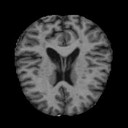

2. label = 0


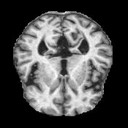

3. label = 3


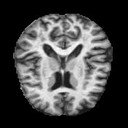

4. label = 3


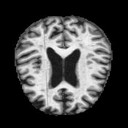

5. label = 2


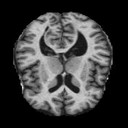

6. label = 2


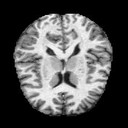

7. label = 2


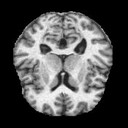

8. label = 2


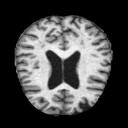

9. label = 3


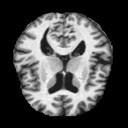

10. label = 2


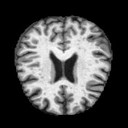

In [22]:
def display_images(df, n=10):
    """
    Display the first n grayscale images (numpy arrays) from df
    along with their labels. Assumes df has columns 'image' and 'label'.
    """
    for i, (_, row) in enumerate(df.head(n).iterrows(), start=1):
        pixels = bytes_to_pixels(row["image"])
        label = row.get("label", "")
        # Create a PIL image in 'L' mode (8-bit pixels, black and white)
        img = Image.fromarray(pixels.astype("uint8"), mode="L")
        print(f"{i}. label = {label}")
        display(img)
display_images(df)